### Import dependencies

In [1]:
import numpy as np
import scipy as sp
import netCDF4 as nC4
import lmoments3 as lm3
# import lmoments3.distr
# import lmoments3.stats
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import eofs
from cdo import Cdo
cdo = Cdo(tempdir='/network/aopp/chaos/pred/leach/.cdo_temp_files1')
# uncomment the below if you want to clean up the temporary directory
cdo.cleanTempDir()
import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import xarray as xr
import xskillscore as xs
import os
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
import glob
import datetime
import time
import multiprocessing
import tqdm
import cmocean
from shapely.geometry.polygon import LinearRing

import pyarrow as pa
import pyarrow.parquet as pq

sys.path.append('/home/leach/Downloads/')
import ScientificColourMaps6 as SCM6

from IPython.display import display, clear_output

# import my own statistics repository
from mystatsfunctions import LMoments,OLSE

## Matplotlib rcparams setup:
matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400
matplotlib.rcParams['image.cmap']='cmo.ice'
matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
# matplotlib.rcParams['axes.labelweight']=300
matplotlib.rcParams['legend.frameon']=False
matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'
matplotlib.rcParams['errorbar.capsize']=5
matplotlib.rcParams['hist.bins']='auto'
plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [2]:
## plotting functions:

def add_lat_lon_ticks(ax,lat=True,lon=True):
    if lon:
        ax.set_xticks(np.arange(-20,50,10), crs=crs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
    if lat:
        ax.set_yticks(np.arange(40,75,10), crs=crs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

## Import Data

#### Useful definitions
Defines the PRUDENCE region extents and imports the a land-sea mask.

In [3]:
## define EU domain:
EU_rg = "-27,45,33,73.5"

## define PRUDENCE region extents:
PD_rg = dict(zip(['BI','IP','FR','CE','SC','AL','MD','EE'],['-10,2,50,59','-10,3,36,44','-5,5,44,50','2,16,48,55','5,30,55,70','5,15,44,48','3,25,36,44','16,30,44,55']))
print(PD_rg)

## get land-sea mask & inversion:
lsm = cdo.setctomiss('0',input= '-gtc,0.5 ../../ERA5/ERA5_land_sea_mask.nc')
lsm_inv = cdo.setctomiss('0',input= '-ltc,0.5 ../../ERA5/ERA5_land_sea_mask.nc')

{'BI': '-10,2,50,59', 'IP': '-10,3,36,44', 'FR': '-5,5,44,50', 'CE': '2,16,48,55', 'SC': '5,30,55,70', 'AL': '5,15,44,48', 'MD': '3,25,36,44', 'EE': '16,30,44,55'}


In [4]:
experiment_index = pd.DataFrame(columns=['PI_co2','INCR_co2'])
experiment_index.loc['2019-02-17'] = ['b2hi','b2hk']
experiment_index.loc['2019-02-23'] = ['b2ht','b2hu']
experiment_index.loc['2019-02-11'] = ['b2i2','b2i3']
experiment_index.loc['2019-02-04'] = ['b2jn','b2jo']

### mx2t over EU domain
Retrieve European max temperatures in operational / reduced CO$_2$ / increased CO$_2$ forecasts.

In [5]:
op = []
inc = []
pi = []

for fcdate in experiment_index.index:
    
    pf = xr.open_dataset('../../OPERATIONAL/EU_FEB_19/sfc/'+fcdate+'_sfc.nc').mx2t.loc['2019-02-25':'2019-02-27'].max('time')
    cf = xr.open_dataset('../../OPERATIONAL/EU_FEB_19/sfc/ctrl/'+fcdate+'_sfc.nc').mx2t.loc['2019-02-25':'2019-02-27'].max('time')
    op += [xr.concat([pf,cf.expand_dims({'number':[51]})],dim='number').expand_dims({'inidate':[fcdate]})]
    
    pf.close()
    cf.close()
    
    pf = xr.open_dataset("../../IFS_exp/Feb_2019/sfc/"+experiment_index.loc[fcdate,'PI_co2']+"_sfc_pf.nc").mx2t.loc['2019-02-25':'2019-02-27'].max('time')
    cf = xr.open_dataset("../../IFS_exp/Feb_2019/sfc/"+experiment_index.loc[fcdate,'PI_co2']+"_sfc_cf.nc").mx2t.loc['2019-02-25':'2019-02-27'].max('time')
    pi += [xr.concat([pf,cf.expand_dims({'number':[51]})],dim='number').expand_dims({'inidate':[fcdate]})]
    
    pf.close()
    cf.close()

    pf = xr.open_dataset("../../IFS_exp/Feb_2019/sfc/"+experiment_index.loc[fcdate,'INCR_co2']+"_sfc_pf.nc").mx2t.loc['2019-02-25':'2019-02-27'].max('time')
    cf = xr.open_dataset("../../IFS_exp/Feb_2019/sfc/"+experiment_index.loc[fcdate,'INCR_co2']+"_sfc_cf.nc").mx2t.loc['2019-02-25':'2019-02-27'].max('time')
    inc += [xr.concat([pf,cf.expand_dims({'number':[51]})],dim='number').expand_dims({'inidate':[fcdate]})]
    
    pf.close()
    cf.close()
    
op = xr.concat(op,dim='inidate').expand_dims({'experiment':['operational']})
pi = xr.concat(pi,dim='inidate').expand_dims({'experiment':['pi-CO2']})
inc = xr.concat(inc,dim='inidate').expand_dims({'experiment':['incr-CO2']})

all_event_data = xr.concat([op,pi,inc],dim='experiment')

Get corresponding ERA5 data.

In [6]:
ERA5_event_data = xr.open_dataset('../../ERA5/EU_FEB_19/ERA5_sfc_2019.nc').mx2t.loc['2019-02-25':'2019-02-27'].max('time')

Get corresponding M-climate (reforecast) data.

In [7]:
rfc_dates = {
    '2019-02-04':['2019-01-'+'{:0>2}'.format(x) for x in [21,24,28,31]]+['2019-02-'+'{:0>2}'.format(x) for x in [4,7,11,14,18]],
    '2019-02-11':['2019-01-'+'{:0>2}'.format(x) for x in [28,31]]+['2019-02-'+'{:0>2}'.format(x) for x in [4,7,11,14,18,21,25]],
    '2019-02-17':['2019-01-'+'{:0>2}'.format(x) for x in [31]]+['2019-02-'+'{:0>2}'.format(x) for x in [4,7,11,14,18,21,25,28]],
    '2019-02-23':['2019-02-'+'{:0>2}'.format(x) for x in [7,11,14,18,21,25,28]]+['2019-03-'+'{:0>2}'.format(x) for x in [4,7]],
}

basedir = '/network/aopp/chaos/pred/leach/OPERATIONAL/EU_FEB_19/sfc/M-climate/2019-02-17/'

rfc_days = {
    '2019-02-04':[x-4 for x in [25,26,27]],
    '2019-02-11':[x-11 for x in [25,26,27]],
    '2019-02-17':[x-17 for x in [25,26,27]],
    '2019-02-23':[x-23 for x in [25,26,27]],
}

def get_rfc_data(fcdate):
    
    print('getting rfc_data for '+fcdate)
    
    rfc_data = []

    for i,rfc_date in enumerate(rfc_dates[fcdate]):

        cf_file = basedir+'rfc_init_'+rfc_date+'_cf.nc'
        pf_file = basedir+'rfc_init_'+rfc_date+'_pf.nc'

        year,mon,day = [int(x) for x in rfc_date.split('-')]
        datetimes = ','.join([(datetime.datetime(year,mon,day)+datetime.timedelta(days=y)-pd.DateOffset(years=x)).strftime('%Y-%m-%d') for x in np.arange(1,21) for y in rfc_days[fcdate]])
        
        cf = xr.open_dataset(cdo.yearmax(input="-select,date="+datetimes+" -selname,mx2t6 "+cf_file),chunks = {'time':10}).expand_dims({'number':[11]})
        pf = xr.open_dataset(cdo.yearmax(input="-select,date="+datetimes+" -selname,mx2t6 "+pf_file),chunks = {'time':10})
        rfc_data += [xr.concat([pf,cf],dim='number').stack(rfc_number=['time','number']).assign_coords(rfc_number=np.arange(i*220,(i+1)*220))]
        cf.close()
        pf.close()

    return xr.concat(rfc_data,dim='rfc_number').expand_dims({'inidate':[fcdate]})

In [8]:
P1 = multiprocessing.Pool(processes=4)
all_rfc_data = P1.map(get_rfc_data,list(rfc_dates.keys()))
P1.close()

all_rfc_data = xr.concat(all_rfc_data,dim='inidate')

getting rfc_data for 2019-02-04getting rfc_data for 2019-02-17getting rfc_data for 2019-02-11getting rfc_data for 2019-02-23





#### Postprocessing
Postprocess to extract the regional averages for each of the data sources.

In [9]:
## derive regional data:

lsm_xr = xr.open_dataset(lsm).lsm.fillna(0).astype(bool)
lsm_xr = lsm_xr.assign_coords(longitude=(((lsm_xr.longitude + 180) % 360) - 180)).sortby('longitude')

PD_rg_xr = pd.DataFrame(columns=['lon_1','lon_2','lat_1','lat_2'])

for RG in PD_rg.keys():
    PD_rg_xr.loc[RG] = [float(x) for x in PD_rg[RG].split(',')]
    
PD_rg_xr.loc['EU'] = [-27,45,33,73.5]

In [10]:
region_data_event = []
ERA5_data_event = []
region_event_data_rfc = []

for RG in PD_rg_xr.index:
    
    lsm_RG = lsm_xr.sel(longitude=slice(PD_rg_xr.loc[RG,'lon_1'],PD_rg_xr.loc[RG,'lon_2']),latitude=slice(PD_rg_xr.loc[RG,'lat_2'],PD_rg_xr.loc[RG,'lat_1']))
    lat_weights = np.cos(np.deg2rad(lsm_RG.latitude))
    
    # ensembles
    rg_event_data = all_event_data.sel(longitude=slice(PD_rg_xr.loc[RG,'lon_1'],PD_rg_xr.loc[RG,'lon_2']),latitude=slice(PD_rg_xr.loc[RG,'lat_2'],PD_rg_xr.loc[RG,'lat_1']))
    region_data_event += [rg_event_data.where(lsm_RG).weighted(lat_weights).mean(['latitude','longitude']).expand_dims({'RG':[RG]})]
    
    # M-climate
    rg_event_data_rfc = all_rfc_data.mx2t6.sel(longitude=slice(PD_rg_xr.loc[RG,'lon_1'],PD_rg_xr.loc[RG,'lon_2']),latitude=slice(PD_rg_xr.loc[RG,'lat_2'],PD_rg_xr.loc[RG,'lat_1']))
    region_event_data_rfc += [rg_event_data_rfc.where(lsm_RG).weighted(lat_weights).mean(['latitude','longitude']).expand_dims({'RG':[RG]})]
    
    # ERA5
    rg_ERA5_data = ERA5_event_data.sel(longitude=slice(PD_rg_xr.loc[RG,'lon_1'],PD_rg_xr.loc[RG,'lon_2']),latitude=slice(PD_rg_xr.loc[RG,'lat_2'],PD_rg_xr.loc[RG,'lat_1']))
    ERA5_data_event += [rg_ERA5_data.where(lsm_RG).weighted(lat_weights).mean(['latitude','longitude']).expand_dims({'RG':[RG]})]
    
region_data_event = xr.concat(region_data_event,dim='RG')
ERA5_data_event = xr.concat(ERA5_data_event,dim='RG')
region_event_data_rfc = xr.concat(region_event_data_rfc,dim='RG').compute()

## add a "counterfactual" experiment = operational + (1/2) * ( pi-CO2 - incr-CO2)
region_data_event_plus_cf = xr.concat([region_data_event,(region_data_event.sel(experiment='operational')+((region_data_event.sel(experiment='pi-CO2')-region_data_event.sel(experiment='incr-CO2'))/2)).expand_dims('experiment').assign_coords(experiment=['counterfactual'])],dim='experiment')

Get the CO$_2$ signal for the map & significance level with 2-sided binomial test

In [11]:
event_tasmax_map = ((all_event_data.loc['incr-CO2'] - all_event_data.loc['pi-CO2'])/2).sortby('inidate')
sign_test_tasmax = xr.DataArray(sp.stats.binom(event_tasmax_map.number.size,0.5).cdf((event_tasmax_map>0).sum('number')),coords=event_tasmax_map.count('number').coords)

### EVA
Fit generalised extreme values to all of the various samples (over ensemble dimension for each experiment / lead / region combination) and extract PDF / CDF at ERA5 event value.

In [12]:
## redo bootstrap with LMoments module

N_boot = 100000

GEV = LMoments.gev()
GEV.fit(np.moveaxis(region_data_event_plus_cf.values[...,np.random.choice(51,51*N_boot)].reshape(9,4,4,-1,51),-1,0))

region_data_CDF = xr.DataArray(GEV.cdf(ERA5_data_event.values[:,None,None,None]),
                               dims=['RG', 'experiment', 'inidate', 'sample'],
                               coords=dict(RG=region_data_event_plus_cf.RG,experiment=region_data_event_plus_cf.experiment,inidate=region_data_event_plus_cf.inidate,sample=np.arange(N_boot))
                              ).sortby('inidate').sortby('experiment').stack(index=['RG','experiment','inidate','sample']).to_pandas()

region_data_PDF = xr.DataArray(GEV.pdf(ERA5_data_event.values[:,None,None,None]),
                               dims=['RG', 'experiment', 'inidate', 'sample'],
                               coords=dict(RG=region_data_event_plus_cf.RG,experiment=region_data_event_plus_cf.experiment,inidate=region_data_event_plus_cf.inidate,sample=np.arange(N_boot))
                              ).sortby('inidate').sortby('experiment').stack(index=['RG','experiment','inidate','sample']).to_pandas()

/network/aopp/chaos/pred/leach/myfunctions/mystatsfunctions/LMoments.py:244: RuntimeWarning: invalid value encountered in power
  cdf = np.exp(-1*(1-self.k*((x-self.X)/self.a))**(1/self.k))
/network/aopp/chaos/pred/leach/myfunctions/mystatsfunctions/LMoments.py:231: RuntimeWarning: invalid value encountered in power
  pdf = (1/self.a) * ( 1-self.k*( (x-self.X)/self.a ) )**( (1/self.k)-1 ) * np.exp( -1*(1-self.k*( (x-self.X)/self.a) )**(1/self.k) )


Draw a table of percentage changes in risk between operational (factual) and pi-CO$_2$ (counterfactual) ensembles.

In [13]:
region_data_probabilities_boot_quants = ((1-region_data_CDF.xs('operational',level=1))/(1-region_data_CDF.xs('pi-CO2',level=1))).replace(0,np.nan).dropna().groupby(['RG','inidate']).quantile([0.05,0.17,0.33,0.5,0.67,0.83,0.95]).unstack()
(region_data_probabilities_boot_quants.unstack(level=1).swaplevel(0,1,axis=1).sort_index(axis=1)-1).style.format("{:.1%}").background_gradient(cmap=sn.color_palette('RdYlGn',as_cmap=True),vmin=-1,vmax=1)

## Create the figure
- 4 panel map at different leads plus boxplots of absolute impact + probabilistic impact for operational | pi & incr | pi

Definitions for the custom boxplots:

In [14]:
## First boxplot type- shows CI of median & 5-95 % ensemble spread.

def custom_boxplot(x,y,ax,width=0.2,n_boot=1000,**kwargs):
    # vertically oriented boxplot
    
    ## compute median & confidence:
    box_med = np.median(y)
    box_med_boot = y[np.random.choice(y.size,y.size*n_boot)].reshape(y.size,-1)
    box_med_ci = np.quantile(np.median(box_med_boot,axis=0),[0.05,0.95])
    
    ## compute ensemble spread
    box_ens_ci = np.quantile(y,[0.05,0.95])
    
    ax.fill_between([x,x+width],*box_med_ci,lw=0,**kwargs)
    if 'alpha' in kwargs.keys():
        kwargs['alpha'] = kwargs['alpha']/2
    else:
        kwargs['alpha'] = 0.5
    ax.fill_between([x,x+width],*box_ens_ci,lw=0,**kwargs)
    ax.hlines(box_med,x,x+width,lw=1,color='k')
    
## Second boxplot type- shows CI of given data.

def custom_boxplot_prob(x,y,ax,width=0.2,**kwargs):
    # vertically oriented boxplot
    
    ## compute median & confidence:
    box_med = np.median(y)
    
    ## compute ensemble spread
    box_ens_ci = np.quantile(y,[0.05,0.95])
    
    if box_med == np.inf:
        box_med = 1e6
        
    box_ens_ci = np.where(box_ens_ci==np.inf,1e6,box_ens_ci)
    box_ens_ci = np.where(np.isnan(box_ens_ci),1e6,box_ens_ci)
    
#     ax.fill_between([x,x+width],*box_med_ci,lw=0,**kwargs)
    if 'alpha' in kwargs.keys():
        kwargs['alpha'] = kwargs['alpha']/2
    else:
        kwargs['alpha'] = 0.5
    ax.fill_between([x,x+width],*box_ens_ci,lw=0,**kwargs)
    ax.hlines(box_med,x,x+width,lw=1,color='k')

/network/aopp/chaos/pred/leach/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
/network/aopp/chaos/pred/leach/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: PerformanceWarning: indexing past lexsort depth may impact performance.


''

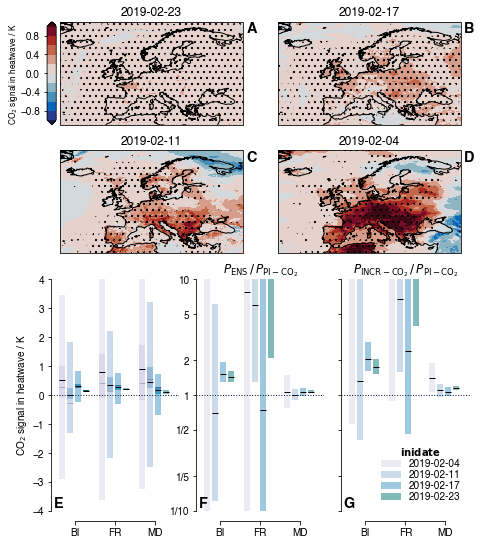

In [17]:
fig = plt.figure(figsize=(7.5,9))

gs = fig.add_gridspec(4,6,wspace=0.3,hspace=0.25)

map_ax = [fig.add_subplot(gs[i//2,3*(i%2):3*(i%2+1)],projection=crs.PlateCarree()) for i in np.arange(4)]

boxplot_ax = [fig.add_subplot(gs[2:,2*(i%3):2*(i%3+1)]) for i in np.arange(3)]

## plot the maps

for i,axes in enumerate(map_ax):
    event_tasmax_map.isel(inidate=3-i).mean('number').plot(ax=axes,transform=crs.PlateCarree(),add_colorbar=False,levels=np.linspace(-1,1,11),extend='both',cmap=cmocean.cm.balance,rasterized=True)
    (sign_test_tasmax>0.9).isel(inidate=3-i).plot.contourf(ax=axes,alpha=0,levels=[-0.5,0.5,1],hatches=[None,'..'],add_colorbar=False)
    
axins = inset_axes(map_ax[0], width="5%",height="100%",loc='lower left',bbox_to_anchor=(-0.07, 0.00, 1, 1),bbox_transform=map_ax[0].transAxes,borderpad=0)
cbar=plt.colorbar(map_ax[0].collections[0],cax=axins,extend='both')
cbar.set_label('CO$_2$ signal in heatwave / K',labelpad=0,fontsize='small')
axins.yaxis.set_ticks_position('left')
axins.yaxis.set_label_position('left')
    
[a.set_xlim(-27,45) for a in map_ax]
[a.set_ylim(33,73.5) for a in map_ax]
[a.coastlines() for a in map_ax]
[a.set_title(event_tasmax_map.inidate[3-i].values[()]) for i,a in enumerate(map_ax)]
[a.text(1.02,1,['A','B','C','D'][i],transform=a.transAxes,fontweight='bold',fontsize='x-large',va='top',ha='left') for i,a in enumerate(map_ax)]

## plot the boxplots

### absolute boxplot

abs_boxplot_data = ((region_data_event.loc[:,'incr-CO2']-region_data_event.loc[:,'pi-CO2'])/2).sortby('inidate').stack(index=('RG','inidate','number')).to_pandas()
abs_boxplot_data_alt = (region_data_event.loc[:,'operational']-region_data_event.loc[:,'pi-CO2']).sortby('inidate').stack(index=('RG','inidate','number')).to_pandas()
abs_boxplot_palette = sn.color_palette('PuBuGn',4)

choose_regions = np.array(['BI','FR','MD'])

box_sep = 1
subbox_sep = 0.2

for i,RG in enumerate(choose_regions):
    for ii,inidate in enumerate(abs_boxplot_data.index.levels[1]):
        custom_boxplot(i*box_sep+ii*subbox_sep,abs_boxplot_data.loc[(RG,inidate)].values,ax=boxplot_ax[0],width=0.15,n_boot=10000,color=abs_boxplot_palette[ii])
        boxplot_ax[0].hlines(np.median(abs_boxplot_data_alt.loc[(RG,inidate)].values),i*box_sep+ii*subbox_sep,i*box_sep+ii*subbox_sep+0.15,lw=1,color='k',alpha=0.2)

### p op | pi

prob_boxplot_data = ((1-region_data_CDF.xs('operational',level=1))/(1-region_data_CDF.xs('pi-CO2',level=1))).replace(0,np.nan).dropna()
prob_boxplot_palette = sn.color_palette('PuBuGn',4)

for i,RG in enumerate(choose_regions):
    for ii,inidate in enumerate(prob_boxplot_data.index.levels[1]):
        custom_boxplot_prob(i*box_sep+ii*subbox_sep,prob_boxplot_data.loc[(RG,inidate)].values,ax=boxplot_ax[1],width=0.15,color=prob_boxplot_palette[ii])

### p incr | pi

prob_boxplot_data = ((1-region_data_CDF.xs('incr-CO2',level=1))/(1-region_data_CDF.xs('pi-CO2',level=1))).replace(0,np.nan).dropna()
prob_boxplot_palette = sn.color_palette('PuBuGn',4)

for i,RG in enumerate(choose_regions):
    for ii,inidate in enumerate(prob_boxplot_data.index.levels[1]):
        custom_boxplot_prob(i*box_sep+ii*subbox_sep,prob_boxplot_data.loc[(RG,inidate)].values,ax=boxplot_ax[2],width=0.15,color=prob_boxplot_palette[ii])
        
## set boxplot layout
[sn.despine(ax=a) for a in boxplot_ax]
# [a.spines['left'].set_position(('outward', 10)) for a in boxplot_ax]
[a.spines['bottom'].set_position(('outward', 10)) for a in boxplot_ax]
[a.spines['bottom'].set_bounds(0+subbox_sep*2,2+subbox_sep*2) for a in boxplot_ax]
[a.set_xticks(np.arange(choose_regions.size)+subbox_sep*2) for a in boxplot_ax]
[a.set_xticklabels(choose_regions) for a in boxplot_ax]
[a.set_xlim(-0.2,choose_regions.size) for a in boxplot_ax]
# [a.set_xlabel('region') for a in boxplot_ax]

boxplot_ax[0].axhline(0,ls=':',lw=1)
boxplot_ax[0].set_ylabel('CO$_2$ signal in heatwave / K')
boxplot_ax[0].set_ylim(-4,4)

[a.axhline(1,ls=':',lw=1) for a in boxplot_ax[1:]]
[a.set_yscale('log') for a in boxplot_ax[1:]]
[a.set_ylim(0.1,10) for a in boxplot_ax[1:]]
choose_yticks = list(1/np.array([1,2,5,10])[::-1]) + list(np.array([2,5,10]))
choose_yticklabels = ['1/'+str(x) for x in np.array([2,5,10])[::-1]]+[str(x) for x in np.array([1,2,5,10])]
[a.set_yticks(choose_yticks) for a in boxplot_ax[1:]]
boxplot_ax[1].set_yticklabels(choose_yticklabels)
boxplot_ax[2].set_yticklabels([])
[a.minorticks_off() for a in boxplot_ax[1:]]
boxplot_ax[1].set_title('$P_{\mathrm{ENS}}\,/\,P_{\mathrm{PI-CO}_2}$')
boxplot_ax[2].set_title('$P_{\mathrm{INCR-CO}_2}\,/\,P_{\mathrm{PI-CO}_2}$')
# boxplot_ax[1].set_ylabel('RR / ')

[a.text(0.02,0,['E','F','G'][i],transform=a.transAxes,fontweight='bold',fontsize='x-large',va='bottom',ha='left') for i,a in enumerate(boxplot_ax)]

[boxplot_ax[2].fill_between([],[],[],lw=0,color=prob_boxplot_palette[ii],alpha=0.5,label=inidate) for ii,inidate in enumerate(prob_boxplot_data.index.levels[1])]
boxplot_ax[2].legend(loc='lower right',bbox_to_anchor=(1,0),frameon=False,ncol=1,fontsize='medium',handlelength=2,labelspacing=0.1,title=r'$\bf{inidate}$')

# [fig.savefig('FIGS/Fig4.'+x,dpi=600,bbox_inches='tight') for x in ['png','pdf']]
# fig.dpi=300
''